# Mixed Martial Arts and the UFC


The UFC is the largest MMA promotion company in the world and features some of the highest-level fighters in the sport. As of 2020 the UFC has held over 500 events features fighters in 12 different weight divisions. The data set is a collection of over 5000 fights from the years 1993 to 2019.

Being a huge fan of MMA, I wanted to design some Machine Learning Models to experiment with the avaiable data. The goal is to make a model to predict fight outcomes, and see if it has any usefulness in real world application.

In this particular notebook I reduce the data down to (what I felt was) core stats, so despite this dataset having over 145 features, I reduce it down to height, weight, reach, win streak, lose streak, total wins, total losses, and total draws. In the future I will apply more features to see if the model accuracy improves at all.

In this notebook I use the following algorithms for model building:
* Gaussian Naive Bayes
* Logistic Regression
* Decision Tree
* KNN
* Random Forest
* Support Vector Classifier
* XGBoost
* Artificial Neural Network

The models with the highest accuracy score (Using k-fold cross-validation) on the training data are then accessed on the testing data.

Finally the models that performed well are then applied to the upcoming event (March 6th 2021), to make predictions on fight winners.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Import and clean data for use in models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_df =  pd.read_csv('../input/ufcdata/data.csv')

In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


In [16]:
df = data_df.dropna()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3202 entries, 0 to 5008
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 3.5+ MB


In [18]:
columns=df.select_dtypes(include='object').columns

In [19]:
columns

Index(['R_fighter', 'B_fighter', 'Referee', 'date', 'location', 'Winner',
       'weight_class', 'B_Stance', 'R_Stance'],
      dtype='object')

In [20]:
df.drop(columns=['R_fighter', 'B_fighter', 'Referee', 'date', 'location','weight_class'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
df.select_dtypes(include='object')

,Winner,B_Stance,R_Stance
0,Red,Orthodox,Orthodox
1,Red,Orthodox,Southpaw
2,Red,Orthodox,Orthodox
3,Blue,Switch,Orthodox
4,Blue,Southpaw,Southpaw
...,...,...,...
4887,Red,Orthodox,Orthodox
4901,Red,Orthodox,Orthodox
4923,Red,Orthodox,Orthodox
4967,Red,Orthodox,Orthodox


In [22]:
map_stance = {'Orthodox': 0, 'Switch': 1, 'Southpaw': 2, 'Open Stance': 3}
df['B_Stance'] = df['B_Stance'].replace(map_stance)
df['R_Stance'] = df['R_Stance'].replace(map_stance)

map_winner = {'Red': 0, 'Blue': 1, 'Draw': 2}
df['Winner'] = df['Winner'].replace(map_winner)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [26]:
df.drop(columns=df.select_dtypes(include='bool').columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3202 entries, 0 to 5008
Columns: 138 entries, Winner to R_age
dtypes: float64(134), int64(4)
memory usage: 3.4 MB


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
df['Winner'].unique()

array([0, 1, 2])

In [48]:
df = df[df['Winner'] != 2]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 0 to 5008
Columns: 138 entries, Winner to R_age
dtypes: float64(134), int64(4)
memory usage: 3.3 MB


In [50]:
X = df.drop(columns=['Winner'])
Y = df['Winner']

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [77]:
print("Training size = " + str(X_train.shape[0]))
print("Testing size = " + str(X_test.shape[0]))

Training size = 2363
Testing size = 788


## Model Training and Evaluation on Data using k-fold cross validation

In [78]:
seed = 404
np.random.seed(seed)

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=kfold)
gnb_score = cv_score.mean()
print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print()
print('Gaussian Naive Bayes Average Score:')
print(gnb_score)
print()

Gaussian Naive Bayes K-fold Scores:
[0.60337553 0.59915612 0.6371308  0.51271186 0.59322034 0.55508475
 0.58898305 0.6059322  0.58050847 0.5720339 ]

Gaussian Naive Bayes Average Score:
0.584813702352857



In [80]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 10000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)
lr_score = cv_score.mean()
print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print()
print('Logistic Regression Average Score:')
print(lr_score)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression K-fold Scores (training):
[0.6835443  0.67088608 0.62447257 0.65677966 0.63559322 0.69915254
 0.6779661  0.68220339 0.61864407 0.62288136]

Logistic Regression Average Score:
0.6572123292569548


In [81]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(dt, X_train, y_train.values.ravel(), cv=kfold)
dt_score = cv_score.mean()
print('Decision Tree K-fold Scores:')
print(cv_score)
print()
print('Decision Tree Average Score:')
print(dt_score)

Decision Tree K-fold Scores:
[0.5907173  0.56962025 0.55696203 0.55508475 0.58050847 0.63559322
 0.54661017 0.55932203 0.55508475 0.52966102]

Decision Tree Average Score:
0.5679163984838732


In [82]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(knn, X_train, y_train.values.ravel(), cv=kfold)
knn_score = cv_score.mean()
print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(knn_score)

KNN K-fold Scores):
[0.60337553 0.5443038  0.61603376 0.59322034 0.59322034 0.54661017
 0.56355932 0.61016949 0.58474576 0.58898305]

KNN Average Score:
0.5844221554745047


In [83]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()
print('Random Forest K-fold Scores:')
print(cv_score)
print()
print('Random Forest Average Score:')
print(rf_score)

Random Forest K-fold Scores:
[0.67510549 0.62869198 0.63291139 0.6440678  0.63559322 0.64830508
 0.65677966 0.68220339 0.62711864 0.6779661 ]

Random Forest Average Score:
0.6508742759064579


In [84]:
from sklearn.svm import SVC

svc = SVC(probability = True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(svc, X_train, y_train.values.ravel(), cv=kfold)
svc_score = cv_score.mean()
print('Support Vector Classification K-fold Scores:')
print(cv_score)
print()
print('Support Vector Classification Average Score:')
print(svc_score)

Support Vector Classification K-fold Scores:
[0.64978903 0.64978903 0.64978903 0.64830508 0.64830508 0.64830508
 0.65254237 0.65254237 0.65254237 0.65254237]

Support Vector Classification Average Score:
0.6504451834370307


In [85]:
import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic',random_state =1, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=kfold)
xgb_score = cv_score.mean()
print('XGBoost Classifier K-fold Scores:')
print(cv_score)
print()
print('XGBoost Classifier Average Score:')
print(xgb_score)

[11:43:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [86]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_Train = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
y_Test = encoder.transform(y_test)

In [87]:
import keras 
from keras.models import Sequential
from keras.layers import Dense
# from keras import layers, models, optimizers


def create_model():
    model = Sequential()
    
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(128, activation='tanh'))    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [88]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold

seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)


kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(model, X_train, y_Train, cv=kfold)
nn_score = cv_score.mean()
print('Neural Network K-fold Scores:')
print(cv_score)
print()
print('Neural Network Average Score:')
print(nn_score)

Neural Network K-fold Scores:
[0.65400844 0.61181435 0.5907173  0.6440678  0.63559322 0.64830508
 0.65254237 0.66949153 0.62711864 0.65254237]

Neural Network Average Score:
0.6386201101337339


## Best performing models

With the training accuracy in mind, we will grab the top 3 models and evaluate them on the testing set

In [92]:
scores = [['Gaussian Naive Bayes', gnb_score],
 ['Logistic Regression', lr_score],
 ['Random Forest', rf_score],
 ['Decision Tree', dt_score],
 ['K-Nearest Neighbor', knn_score],
 ['Support Vector Classifier', svc_score],
 ['XGBoost', xgb_score],
 ['Neural Network', nn_score]]

df_scores = pd.DataFrame(scores,
                         columns = ['Model', 'Score Average']
                        )
df_scores

,Model,Score Average
0,Gaussian Naive Bayes,0.584814
1,Logistic Regression,0.657212
2,Random Forest,0.650874
3,Decision Tree,0.567916
4,K-Nearest Neighbor,0.584422
5,Support Vector Classifier,0.650445
6,XGBoost,0.638620
7,Neural Network,0.638620


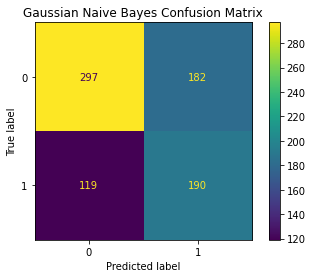

Gaussian Naive Bayes Model Accuracy (on testing set): 
0.618020304568528


In [94]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

GNB = GaussianNB()
GNB_model = GNB.fit(X_train, y_train.values.ravel())
y_pred = GNB_model.predict(X_test)

disp = plot_confusion_matrix(GNB_model, X_test, y_test)
disp.ax_.set_title('Gaussian Naive Bayes Confusion Matrix')

plt.show()
print('Gaussian Naive Bayes Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

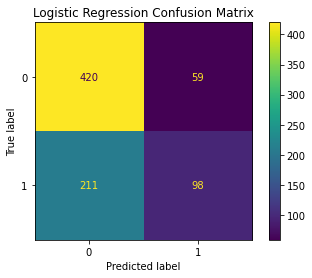

Logistic Regression Model Accuracy (on testing set): 
0.6573604060913706


In [96]:
lr = LogisticRegression(max_iter = 10000)
lr_model = lr.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

disp = plot_confusion_matrix(lr_model, X_test, y_test)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show()
print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

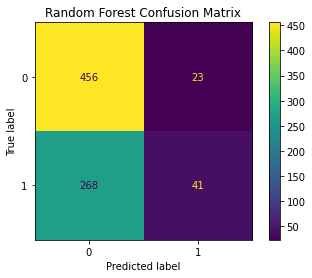

Random Forest Model Accuracy (on testing set): 
0.6307106598984772


In [97]:
rf = RandomForestClassifier(random_state = 1)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

print('Random Forest Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

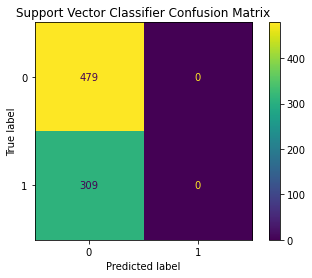

SVC Model Accuracy (on testing set): 
0.6078680203045685


In [98]:
svc = SVC(probability = True)
svc_model = svc.fit(X_train, y_train.values.ravel())
y_pred = svc_model.predict(X_test)
disp = plot_confusion_matrix(svc_model, X_test, y_test)
disp.ax_.set_title('Support Vector Classifier Confusion Matrix')

plt.show()

print('SVC Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

# Prediction Time

# UFC 259: Blachowicz vs Adesanya

### Title fights (5 rounds):
Jan Blachowicz vs Israel Adesanya

Amanda Nunes vs Megan Anderson

Petr Yan vs Aljamain Sterling

### 3 round fights:
Islam Makhachev vs Drew Dober

Thiago Santos vs Aleksandar Rakic


## The Stats: ([https://www.espn.co.uk/mma/fightcenter/_/id/600001860/league/ufc](http://))
### Fight 1
#### Jan Blachowicz (Blue):
* Current Lose Streak: 0
* Current Win Streak: 4
* Draws: 0
* Losses: 8
* Wins: 27
* Stance: Orthodox
* Height: 188
* Reach: 198
* Weight: 205

#### Israel Adesanya (Red):
* Current Lose Streak: 0
* Current Win Streak: 20
* Draws: 0
* Losses: 0
* Wins: 20
* Stance: Switch
* Height: 193
* Reach: 203
* Weight: 193 (speculation based on interview, weigh-ins to come)


### Fight 2
#### Amanda Nunes (Blue):
* Current Lose Streak: 0
* Current Win Streak: 11
* Draws: 0
* Losses: 4
* Wins: 20
* Stance: Orthodox
* Height: 173
* Reach: 165
* Weight: 145

#### Megan Anderson (Red):
* Current Lose Streak: 0
* Current Win Streak: 2
* Draws: 0
* Losses: 4
* Wins: 11
* Stance: Orthodox
* Height: 183
* Reach: 183
* Weight: 145

### Fight 3
#### Petr Yan (Blue):
* Current Lose Streak: 0
* Current Win Streak: 10
* Draws: 0
* Losses: 1
* Wins: 15
* Stance: Switch
* Height: 170
* Reach: 170
* Weight: 135

#### Aljamain Sterling (Red):
* Current Lose Streak: 0
* Current Win Streak: 5
* Draws: 0
* Losses: 3
* Wins: 19
* Stance: Orthodox
* Height: 170
* Reach: 180
* Weight: 135

### Fight 4
#### Islam Makhachev (Blue):
* Current Lose Streak: 0
* Current Win Streak: 6
* Draws: 0
* Losses: 1
* Wins: 18
* Stance: Orthodox
* Height: 178
* Reach: 178
* Weight: 155

#### Drew Dober (Red):
* Current Lose Streak: 0
* Current Win Streak: 3
* Draws: 0
* Losses: 9
* Wins: 23
* Stance: Southpaw
* Height: 173
* Reach: 178
* Weight: 155

### Fight 5
#### Thiago Santos (Blue):
* Current Lose Streak: 2
* Current Win Streak: 0
* Draws: 0
* Losses: 8
* Wins: 21
* Stance: Orthodox
* Height: 188
* Reach: 193
* Weight: 205

#### Aleksandar Rakic (Red):
* Current Lose Streak: 0
* Current Win Streak: 1
* Draws: 0
* Losses: 2
* Wins: 13
* Stance: Orthodox
* Height: 193
* Reach: 198
* Weight: 205

With all the stats available to us, it can create a data frame to feed into our models and get predictions

In [ ]:
columns = X.columns

In [ ]:
fight1 = [5, 0, 4, 0, 8, 27, 0, 188, 198, 205, 0, 20, 0, 0, 20, 1, 193, 293, 193]
fight2 = [5, 0, 11, 0, 4, 20, 0, 173, 165, 145, 0, 2, 0, 4, 11, 0, 183, 183, 145]
fight3 = [5, 0, 10, 0, 1, 15, 1, 170, 170, 135, 0, 5, 0, 3, 19, 0, 170, 180, 135]
fight4 = [3, 0, 6, 0, 1, 18, 0, 178, 178, 155, 0, 3, 0, 9, 23, 2, 173, 178, 155]
fight5 = [3, 2, 0, 0, 8, 21, 0, 188, 193, 205, 0, 1, 0, 2, 13, 0, 193, 198, 205]

df1 = pd.DataFrame(np.array([fight1, fight2, fight3, fight4, fight5]), columns = columns)

# Model Predictions: (0 indicates Red Fighter Wins, 1 indicates Blue Fighter Wins)

## Support Vector Classifier:

In [ ]:
svc_model.predict(df1)

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Drew Dober
* Fight 5 - Aleksandar Rakic

## Random Forest:

In [ ]:
rf_model.predict(df1)

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Islam Makhachev
* Fight 5 - Aleksandar Rakic

## Logistic Regression:

In [ ]:
lr_model.predict(df1)

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Drew Dober
* Fight 5 - Aleksandar Rakic

# Full Feature Modeling
We'll reduce the problem to a binary classification problem, especially with the new scoring system draws don't occur in the UFC anymore.

In [ ]:
df['Winner'].value_counts()

In [ ]:
df = df[df['Winner'] != 'Draw']

In [ ]:
df = df.drop(columns=['R_fighter', 'B_fighter', 'Referee', 'date', 'location', 'title_bout', 'weight_class', 'B_draw', 'R_draw'])

In [ ]:
mapping = {'Orthodox': 0, 'Switch': 1, 'Southpaw': 2, 'Open Stance': 3}
df['B_Stance'] = df['B_Stance'].replace(mapping)
df['R_Stance'] = df['R_Stance'].replace(mapping)

In [ ]:
X = df.drop(columns=['Winner'])
Y = df['Winner']
mapping = {'Red': 0, 'Blue': 1}
Y = Y.replace(mapping)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
seed = 404
np.random.seed(seed)

In [ ]:
gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=kfold)
print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print()
print('Gaussian Naive Bayes Average Score:')
print(cv_score.mean())
print()

In [ ]:
lr = LogisticRegression(max_iter = 10000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)
print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print()
print('Logistic Regression Average Score:')
print(cv_score.mean())

In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(dt, X_train, y_train.values.ravel(), cv=kfold)
print('Decision Tree K-fold Scores:')
print(cv_score)
print()
print('Decision Tree Average Score:')
print(cv_score.mean())

In [ ]:
knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(knn, X_train, y_train.values.ravel(), cv=kfold)
print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(cv_score.mean())

In [ ]:
rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
print('Random Forest K-fold Scores:')
print(cv_score)
print()
print('Random Forest Average Score:')
print(cv_score.mean())

In [ ]:
svc = SVC(probability = True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(svc, X_train, y_train.values.ravel(), cv=kfold)
print('Support Vector Classification K-fold Scores:')
print(cv_score)
print()
print('Support Vector Classification Average Score:')
print(cv_score.mean())

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=kfold)
print('XGBoost Classifier K-fold Scores:')
print(cv_score)
print()
print('XGBoost Classifier Average Score:')
print(cv_score.mean())

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_Train = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
y_Test = encoder.transform(y_test)


def create_model():
    model = Sequential()
    
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(X_train.shape[1]*2, activation='tanh'))
    model.add(Dense(X_train.shape[1]*4, activation='tanh'))
    model.add(Dense(X_train.shape[1]*2, activation='tanh'))    
    model.add(Dense(X_train.shape[1], activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)


kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(model, X_train, y_Train, cv=kfold)
print('Neural Network K-fold Scores:')
print(cv_score)
print()
print('Neural Network Average Score:')
print(cv_score.mean())

In [ ]:
lr = LogisticRegression(max_iter = 2000)
lr_model = lr.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

disp = plot_confusion_matrix(lr_model, X_test, y_test)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show()
print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

In [ ]:
rf = RandomForestClassifier(random_state = 1)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

print('Random Forest Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

In [ ]:
svc = SVC(probability = True)
svc_model = svc.fit(X_train, y_train.values.ravel())
y_pred = svc_model.predict(X_test)
disp = plot_confusion_matrix(svc_model, X_test, y_test)
disp.ax_.set_title('Support Vector Classifier Confusion Matrix')

plt.show()

print('SVC Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',random_state =1, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=kfold)
print('XGBoost Classifier K-fold Scores:')
print(cv_score)
print()
print('XGBoost Classifier Average Score:')
print(cv_score.mean())

# Conclusion

If we look at the current under/over odds in the betting world, most agree with the model predictions for Fight 1 and Fight 5, but only the Random Forest is in line with the odds for Fight 4. Fight 3 has the odds at -110 to -110, so Vegas seems to be split evenly on this fight.

I hope to expand the models to take in more features, and as a fan I can't help but think strike %, take down %, take down defence %, and a number of the various other features definitely come into play when accessing winner outcome.

I hope you enjoyed this!